## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
# import nuctools

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

In [2]:
%matplotlib widget

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


In [263]:
### calc calculate a full energy grid yourself 
# energy_grid = [75, 125]
energy_grid = [750, 825]

### or just give the min/max and the experiment object will do the above
# energy_grid = E_min_max

input_options = {'Add Noise': True,
            'Calculate Covariance': True,
            'Sample TURP': False}

experiment_parameters = {'bw': {'val':0.015,    'unc'   :   0},
                         'trigo': {'val':1e8,    'unc'   :   0},
                         'trigs': {'val':1e8,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

289

In [264]:
spin_groups = [ (3.0,1,0) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

# average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':4.17, '4.0':4.99},
#                                     'Gg'    :   {'3.0':64.0, '4.0':64.0},
#                                     'gn2'    :   {'3.0':46.4, '4.0':35.5}  })
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':4.17, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':75.4, '4.0':35.5}  })                         
                                    
# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
resonance_ladder = pd.read_csv("./UPR_presentation_ladder.csv")


resonance_ladder

,Unnamed: 0,E,Gg,gn2,J,chs,lwave,J_ID,Gn,Gt
0,1,763.126121,61.206123,9.422718,3.0,1.0,0.0,1.0,0.924354,62.130478
1,2,768.937632,59.268165,116.427814,3.0,1.0,0.0,1.0,11.464799,70.732964
2,3,775.663193,61.152390,4.905508,3.0,1.0,0.0,1.0,0.485160,61.637550
3,4,780.052930,69.485494,0.040238,3.0,1.0,0.0,1.0,0.003991,69.489485
4,5,790.179438,60.645243,221.095295,3.0,1.0,0.0,1.0,22.070212,82.715455
5,6,794.026732,67.690695,25.309411,3.0,1.0,0.0,1.0,2.532583,70.223279
6,7,795.073479,65.220241,1.760043,3.0,1.0,0.0,1.0,0.176235,65.396475
7,8,797.901248,63.328705,24.320835,3.0,1.0,0.0,1.0,2.439592,65.768297
8,9,804.745634,66.001232,43.255103,3.0,1.0,0.0,1.0,4.357434,70.358666
9,10,813.765784,65.632117,118.928590,3.0,1.0,0.0,1.0,12.047588,77.679705


### Calculate cross section using SAMMY and run experiment

In [265]:
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'XCT',
    reaction = 'total',
    solve_bayes = False,
    inptemplate= "allexptot_1sg.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR_1',
    keep_runDIR = True,
    shell = 'zsh'
    )

# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.DataFrame({'E':[24.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.read_csv("./UPR_presentation_ladder.csv")


sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = exp.energy_domain,
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)

sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)
theo, par = sammyOUT.pw, sammyOUT.par


In [267]:

exp.run(theo)
# exp.redpar - exp.theo_redpar

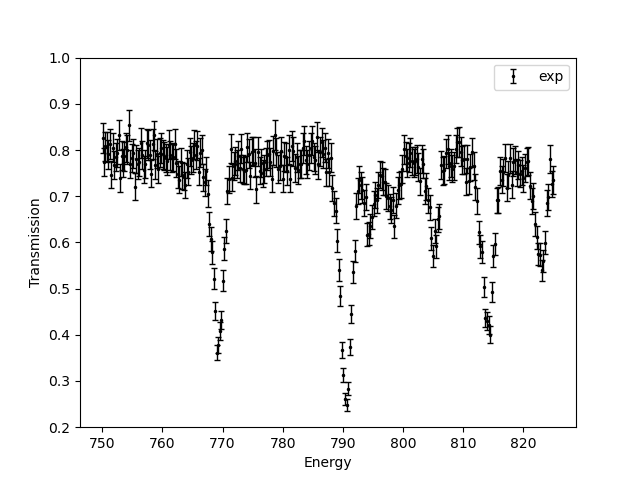

In [274]:
figure()
# plot(theo.E, theo.theo_trans, ms=1, color='r')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([.2, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

In [269]:
from ATARI.utils.datacontainer import DataContainer
d = DataContainer()
d.add_theoretical(Ta_pair, resonance_ladder)
d.add_experimental(exp)
d.fill()


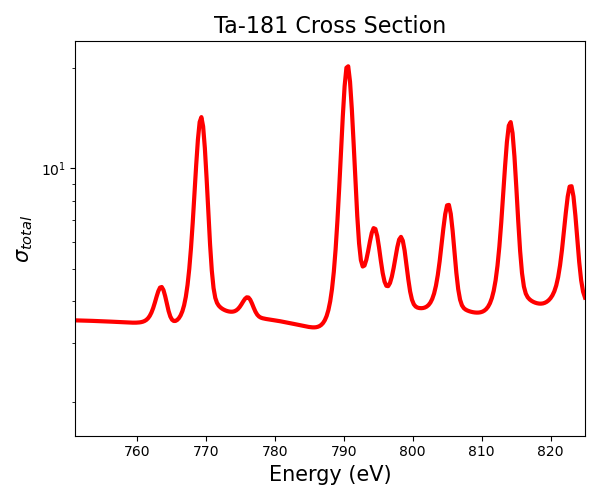

In [284]:


figure(figsize=(6,5))

# errorbar(d.pw_exp.E, d.pw_exp.exp_xs, yerr=d.pw_exp.exp_xs_unc, zorder=2,
#                                 fmt='.', color='k', ecolor='k', linewidth=0.5, markersize=3.5, capsize=2, label='exp')


plot(theo.E, theo.theo_xs, color='r', zorder=0, lw=3)
ylim([1.58, 24])
xlim([751,825])
yscale('log')
# xscale('log')
ylabel(r'$\sigma_{total}$', fontsize=15)
xlabel('Energy (eV)', fontsize=15)
title('Ta-181 Cross Section', fontsize=16)

tight_layout()